<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/EWMA_%26_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

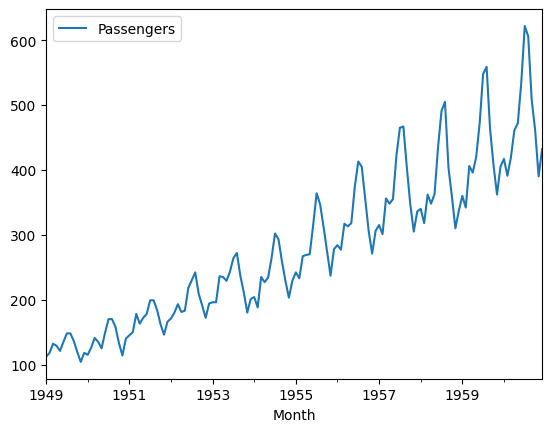

In [6]:
df.plot();

In [7]:
alpha = 0.2

In [8]:
df['EWMA'] = df['Passengers'].ewm(alpha = alpha,adjust = False).mean()

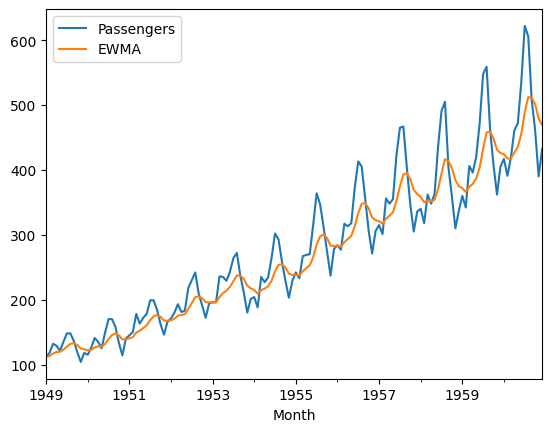

In [9]:
df.plot();

In [10]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
     xhat = alpha * x + (1-alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['manual'] = manual_ewma

<Axes: xlabel='Month'>

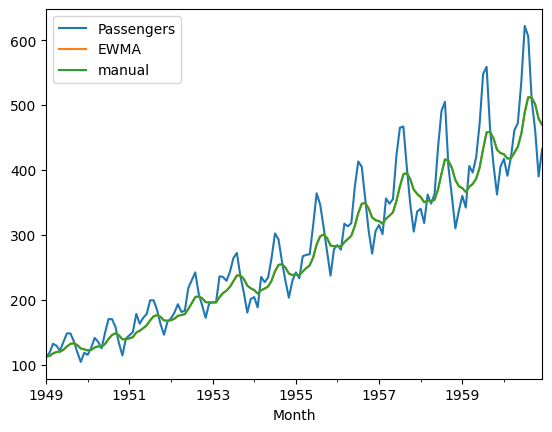

In [12]:
df.plot()

In [13]:
df.head()

,Passengers,EWMA,manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [14]:
df.drop('manual',axis = 1,inplace = True)

# **Holt-Winters**

In [ ]:
!pip install statsmodels

In [16]:
 from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
# 'MS' indicates month
df.index.freq = 'MS'

In [20]:
res = ses.fit(smoothing_level = alpha,optimized = False)

In [21]:
res

In [22]:
res.predict(start=df.index[0],end = df.index[-1])

1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [23]:
df['SES'] = res.predict(start = df.index[0],end = df.index[-1])

In [26]:
#Check values
np.allclose(df['SES'],res.fittedvalues)

True

<Axes: xlabel='Month'>

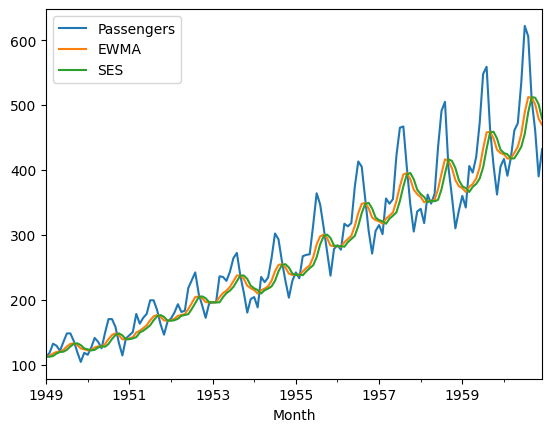

In [27]:
df.plot()

In [28]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [29]:
df['SES-1'] = df['SES'].shift(-1)

In [30]:
df.head()

,Passengers,EWMA,SES,SES-1
Month,,,,
1949-01-01,112,112.0000,112.000,112.0000
1949-02-01,118,113.2000,112.000,113.2000
1949-03-01,132,116.9600,113.200,116.9600
1949-04-01,129,119.3680,116.960,119.3680
1949-05-01,121,119.6944,119.368,119.6944


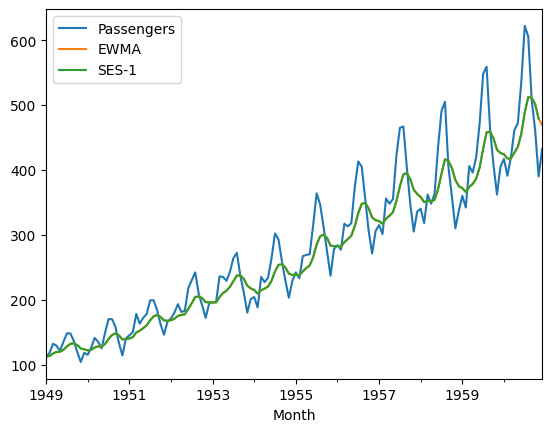

In [31]:
#Wrong
#SES is originally lagging behind 1 step
df[['Passengers','EWMA','SES-1']].plot();

In [37]:
 #Split the data into training and testing sets
 N_test = 12

 #From 0 to stop b4 last 12 rows
 train = df.iloc[:-N_test]

 #Last 12 rows
 test = df.iloc[-N_test:]

In [40]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method = 'legacy-heuristic'
)
res = ses.fit()

In [41]:
#boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

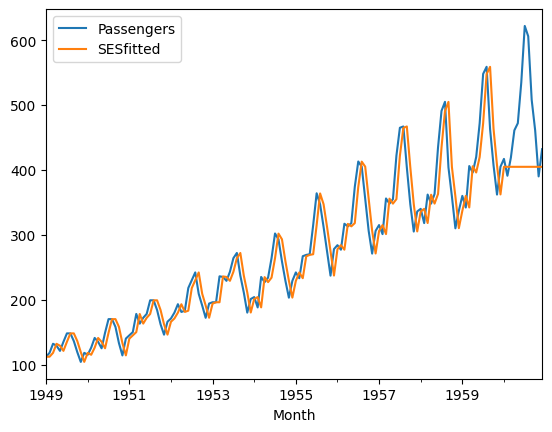

In [45]:
df.loc[train_idx,'SESfitted'] = res.fittedvalues
df.loc[test_idx,'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot();

In [47]:
#smoothing level is 0.995 very close to 1
#which means the predicted value is copied the previous value
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [48]:
from statsmodels.tsa.holtwinters import Holt

In [49]:
holt = Holt(
    df['Passengers'],
    initialization_method = 'legacy-heuristic'
)

In [50]:
res_h = holt.fit()

In [51]:
df['Holt'] = res_h.fittedvalues

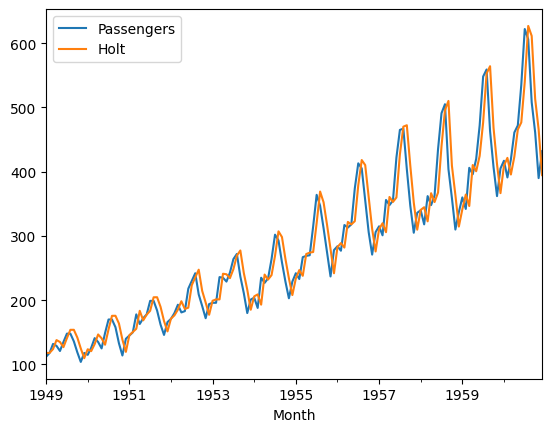

In [52]:
df[['Passengers','Holt']].plot();

<Axes: xlabel='Month'>

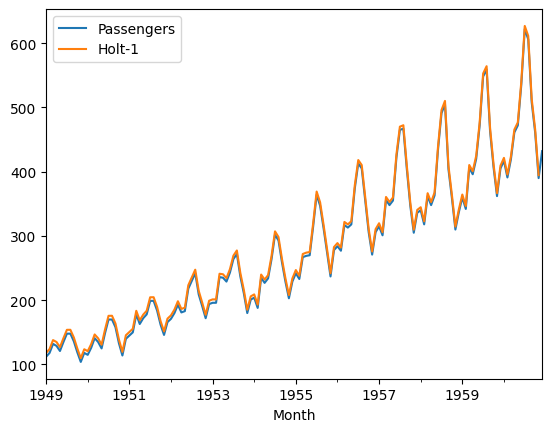

In [53]:
###Wrong
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers','Holt-1']].plot()

In [55]:
holt = Holt(train['Passengers'],initialization_method = 'legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx,'Holt'] = res_h.fittedvalues

In [56]:
df.loc[test_idx,'Holt'] = res_h.forecast(N_test)

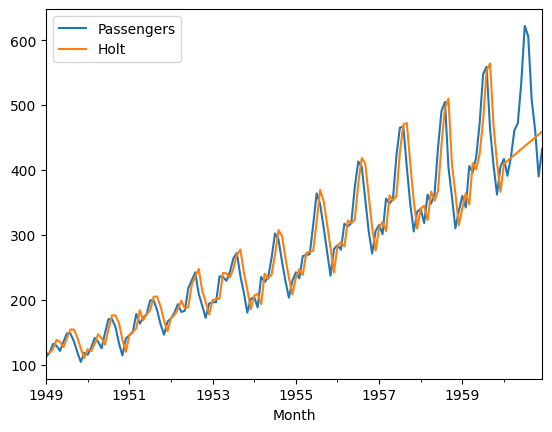

In [57]:
df[['Passengers','Holt']].plot();

In [59]:
 from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [61]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method = 'legacy-heuristic',
    trend = 'add',seasonal = 'add',seasonal_periods = 12
)
res_hw = hw.fit()

In [62]:
df.loc[train_idx,'Holtwinters'] = res_hw.fittedvalues

In [63]:
df.loc[test_idx,'Holtwinters'] = res_hw.forecast(N_test)

<Axes: xlabel='Month'>

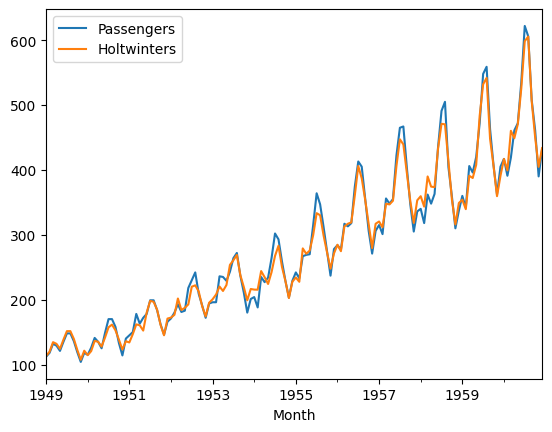

In [64]:
df[['Passengers','Holtwinters']].plot()

In [65]:
def rmse(y,t):
  return np.sqrt( np.mean( (y - t)**2 ) )

In [66]:
def mae(y,t):
  return np.mean( np.abs(y - t) )

In [68]:
print("Train RMSE: ",rmse(train['Passengers'],res_hw.fittedvalues))
print("Test  RMSE: ",rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE:  11.853000976828765
Test  RMSE:  15.543003084126884


In [71]:
print("Train MAE: ",mae(train['Passengers'],res_hw.fittedvalues))
print("Test  MAE: ",mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE:  8.892127530485896
Test  MAE:  10.43776563928059


<Axes: xlabel='Month'>

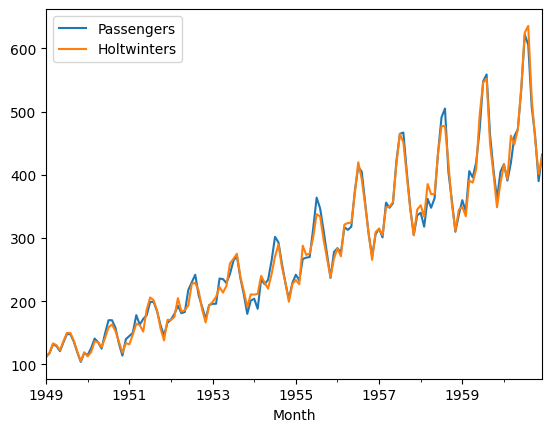

In [75]:
#Since the amplitude increasing over time
#Thus use mulltiplicative seasonality
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method = 'legacy-heuristic',
    trend = 'add',seasonal = 'mul',seasonal_periods = 12
)
res_hw = hw.fit()
df.loc[train_idx,'Holtwinters'] = res_hw.fittedvalues
df.loc[test_idx,'Holtwinters'] = res_hw.forecast(N_test)
df[['Passengers','Holtwinters']].plot()

In [76]:
print("Train RMSE: ",rmse(train['Passengers'],res_hw.fittedvalues))
print("Test  RMSE: ",rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE:  10.153934838980392
Test  RMSE:  16.535212108255575


In [77]:
print("Train MAE: ",mae(train['Passengers'],res_hw.fittedvalues))
print("Test  MAE: ",mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE:  7.552052605073941
Test  MAE:  10.683341165983848


<Axes: xlabel='Month'>

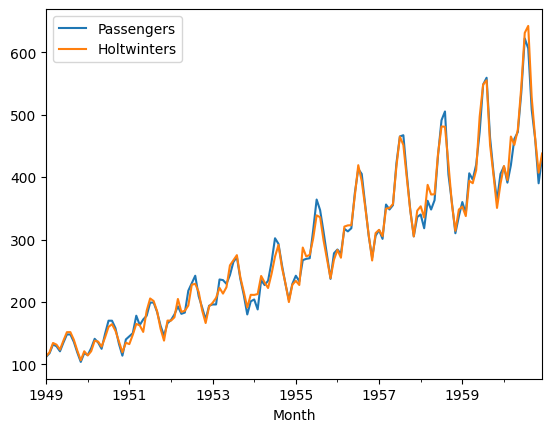

In [78]:
#Use multiplicative trend
#Use multiplicative seasonality
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method = 'legacy-heuristic',
    trend = 'mul',seasonal = 'mul', seasonal_periods = 12
)
res_hw = hw.fit()
df.loc[train_idx,'Holtwinters'] = res_hw.fittedvalues
df.loc[test_idx,'Holtwinters'] = res_hw.forecast(N_test)
df[['Passengers','Holtwinters']].plot()

In [84]:
#Train RMSE becomes better
#Test RMSE becomes worst
#Overfitting
print("Train RMSE: ",rmse(train['Passengers'],res_hw.fittedvalues))
print("Test  RMSE: ",rmse(test['Passengers'],res_hw.forecast(N_test)))

Train RMSE:  9.887178133858725
Test  RMSE:  19.102067803628128


In [83]:
#Train RMSE becomes better
#Test RMSE becomes worst
#Overfitting
print("Train MAE: ",mae(train['Passengers'],res_hw.fittedvalues))
print("Test  MAE: ",mae(test['Passengers'],res_hw.forecast(N_test)))

Train MAE:  7.4087084537494965
Test  MAE:  13.450486213258506
